In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import yaml
import cv2

sys.path.append('/home/schiavazza/code/hpe/')

from vicon_recordings.src.projection import C3dHelper

In [2]:
import matplotlib 
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])

In [3]:
file_path = '/home/schiavazza/data/hpe/vicon_recordings/EDPR_hpe/human_pose_estimation/P000/session/giovanna1.c3d'
c3d_helper = C3dHelper(file_path)

/home/schiavazza/code/hpe/vicon_recordings/venv/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


In [4]:
c3d_helper.calculate_frame_times()
frame = c3d_helper.get_frame_time(17.0 - 9.335795)

/home/schiavazza/code/hpe/vicon_recordings/src/projection.py:30: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, count = scipy.stats.mode(n_points)


In [5]:
vicon_dict = c3d_helper.get_points_dict(frame)
points_all = c3d_helper.get_points_frame(frame)
c3d_helper.points_labels
s = len(c3d_helper.points_labels)
with open("/home/schiavazza/code/hpe/vicon_recordings/data/points.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
image_points = data
image_points = np.ones((s, 3))
vicon_points = np.ones((s, 4))
k = 0
test = [None] * s
for i, l in enumerate(data):
    if l in c3d_helper.points_labels:
        print(l)
        test[k] = l
        p = data[l]
        image_points[k] = [p['x'], p['y'], 1.0]
        vicon_points[k][:3] = vicon_dict[l][:3]
        k += 1

print(test)
# image_points = np.flip(image_points, axis=0)

RASI
LASI
STRN
CLAV
RFHD
LFHD
LSHO
RSHO
['RASI', 'LASI', 'STRN', 'CLAV', 'RFHD', 'LFHD', 'LSHO', 'RSHO']


In [6]:
A = np.zeros((2*s, 12))
for i in range(s):
    A[2*i, :4] = vicon_points[i]
    A[2*i + 1, 4:8] = vicon_points[i]

    A[2*i, 8:] = vicon_points[i] * (-image_points[i][0])
    A[2*i+1, 8:] = vicon_points[i] * (-image_points[i][1])

In [7]:
print(A[:2])
print(vicon_points[0])
print(image_points[0])

print(vicon_points[0] * (-image_points[0][0]))

[[ 1.30921252e+03  2.25943579e+03  1.05525806e+03  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.85408330e+05 -4.92557002e+05 -2.30046256e+05 -2.18000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.30921252e+03  2.25943579e+03  1.05525806e+03  1.00000000e+00
  -2.90645180e+05 -5.01594746e+05 -2.34267289e+05 -2.22000000e+02]]
[1.30921252e+03 2.25943579e+03 1.05525806e+03 1.00000000e+00]
[218. 222.   1.]
[-2.85408330e+05 -4.92557002e+05 -2.30046256e+05 -2.18000000e+02]


In [8]:
points_colors = [cmap(i / s) for i in range(s)]

[218. 222.   1.]
[271. 222.   1.]
[241. 138.   1.]
[239. 123.   1.]
[237.  56.   1.]
[254.  59.   1.]
[273. 121.   1.]
[204. 121.   1.]


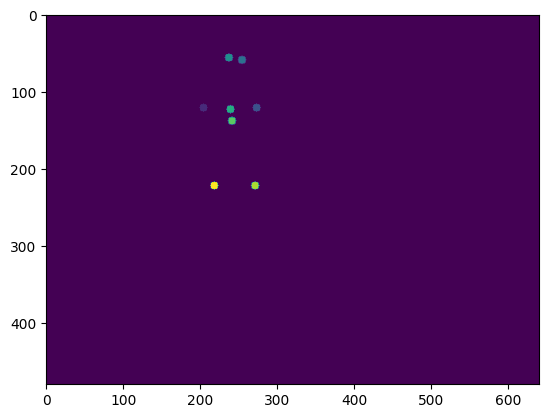

In [9]:
img = np.zeros((480, 640, 1))
for i, p in enumerate(image_points):
    print(p)
    cv2.circle(img, p[:2].astype(int), 5, np.asarray(points_colors[i]) * 255, -1)

plt.imshow(img)

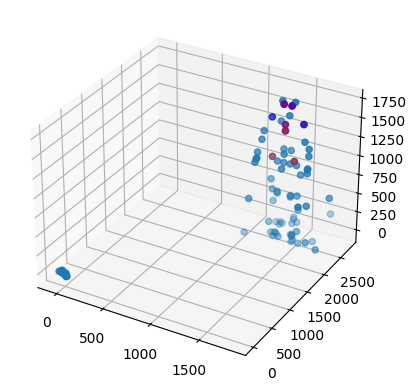

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(points_all[:, 0], points_all[:, 1], points_all[:, 2])
skel = ax.scatter(vicon_points[:,0], vicon_points[:, 1], vicon_points[:, 2], c=points_colors)

In [11]:
vicon_points[-1, :]

array([1.24358545e+03, 2.41627759e+03, 1.48565417e+03, 1.00000000e+00])

In [12]:
image_points[-1]

array([204., 121.,   1.])

[1309.21252441 2259.43579102 1055.25805664]
[1522.74694824 2298.13330078 1045.72766113]
[1414.48400879 2325.83349609 1396.96972656]
[1397.00720215 2368.69091797 1454.66723633]
[1390.81481934 2336.49389648 1727.92529297]
[1467.29467773 2350.33935547 1724.96691895]
[1558.17724609 2452.41650391 1476.43676758]
[1243.58544922 2416.27758789 1485.6541748 ]


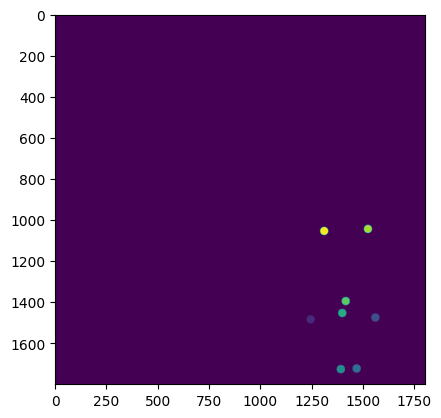

In [13]:
img = np.zeros((1800, 1800, 1))
for i, p in enumerate(vicon_points):
    print(p[:3])
    cv2.circle(img, (int(p[0]), int(p[2])), 20, np.asarray(points_colors[i])*255, -1)

plt.imshow(img)

In [14]:
# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
m = eigenvectors[:, 11]

# reshape m back to a matrix
M = m.reshape(3, 4)

In [15]:
K = np.array([
    [547.703, 0.0, 326.626],
    [0.0, 546.179, 221.795],
    [0.0, 0.0, 1.0]
])
D = np.array([-0.185245, 0.133069, -0.00156419, -0.00172291])

In [35]:
from scipy.optimize import minimize

def error(m):
    projected =  (K @ m.reshape(3, 4) @ vicon_points.transpose()).transpose()
    for r in projected:
        r /= r[-1]

    undistorted = cv2.undistortPoints(image_points[:, :2].astype(np.float64), K, D)
    undistorted = undistorted[:, 0, :]
    undistorted = np.hstack(undistorted, np.ones((undistorted.shapep0)))        
    return (np.linalg.norm(undistorted - projected, axis=1)).sum()

result = minimize(error, m)

ValueError: operands could not be broadcast together with shapes (8,1,2) (8,3) 

In [17]:
x = result.x

In [18]:
P = x.reshape(3, 4)
print(P)

[[-1.66367994e-03 -1.60425577e-04  1.51721462e-04  3.19536296e+00]
 [ 2.54002366e-04 -8.08519420e-04  2.19271975e-03 -8.25096439e-01]
 [-7.30061288e-04  1.08376721e-03 -9.31137649e-04 -4.63567807e+00]]


In [19]:
reconstructed_points = np.zeros((s, 2))
for i in range(s):
    r_image = (K @ P @ vicon_points[i])
    r_image /= r_image[-1]
    print(f"image: {image_points[i]}\nreconstructed: {r_image}")
    reconstructed_points[i] = r_image[:2]

image: [218. 222.   1.]
reconstructed: [218.43799874 222.51865687   1.        ]
image: [271. 222.   1.]
reconstructed: [268.10967856 222.23561665   1.        ]
image: [241. 138.   1.]
reconstructed: [242.78693468 133.77823446   1.        ]
image: [239. 123.   1.]
reconstructed: [238.86761204 122.92245899   1.        ]
image: [237.  56.   1.]
reconstructed: [237.55960331  56.8327907    1.        ]
image: [254.  59.   1.]
reconstructed: [253.20049834  57.95073183   1.        ]
image: [273. 121.   1.]
reconstructed: [273.73227507 121.40991304   1.        ]
image: [204. 121.   1.]
reconstructed: [204.04700732 121.03470567   1.        ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[218.43799874 222.51865687]
[268.10967856 222.23561665]
[242.78693468 133.77823446]
[238.86761204 122.92245899]
[237.55960331  56.8327907 ]
[253.20049834  57.95073183]
[273.73227507 121.40991304]
[204.04700732 121.03470567]
[218. 222.   1.]
[271. 222.   1.]
[241. 138.   1.]
[239. 123.   1.]
[237.  56.   1.]
[254.  59.   1.]
[273. 121.   1.]
[204. 121.   1.]


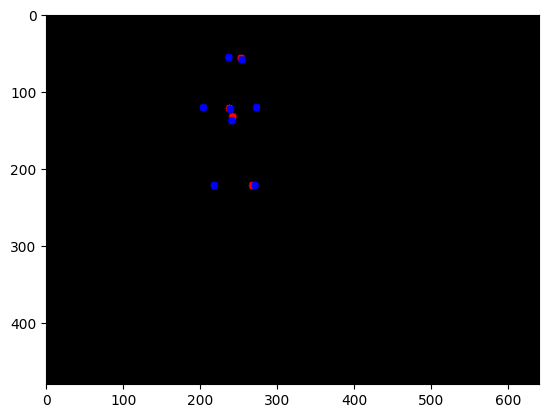

In [20]:
import cv2
img = np.zeros((480, 640, 3))
for i, p in enumerate(reconstructed_points):
    print(p)
    cv2.circle(img, p.astype(int), 5, (255, 0, 0), -1)

for i, p in enumerate(image_points):
    print(p)
    cv2.circle(img, p[:2].astype(int), 5, (0, 0, 255), -1)

plt.imshow(img)

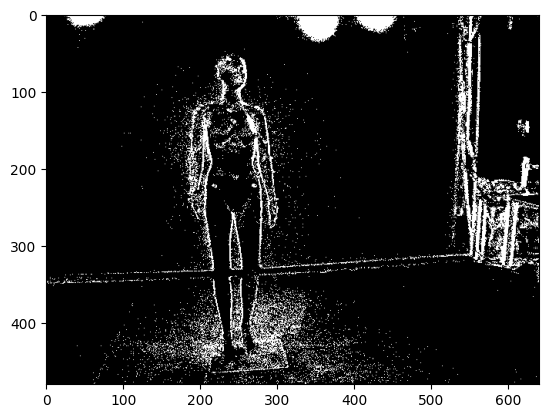

In [21]:
dvs_frame = cv2.imread('/home/schiavazza/code/hpe/vicon_recordings/data/frame.png')
points_to_transform = np.ones((points_all.shape[0], 4))
points_to_transform[:, :3] = points_all[:, :3]
plt.imshow(dvs_frame)

In [22]:
transformed_points = (K @ P @ points_to_transform.transpose()).transpose()

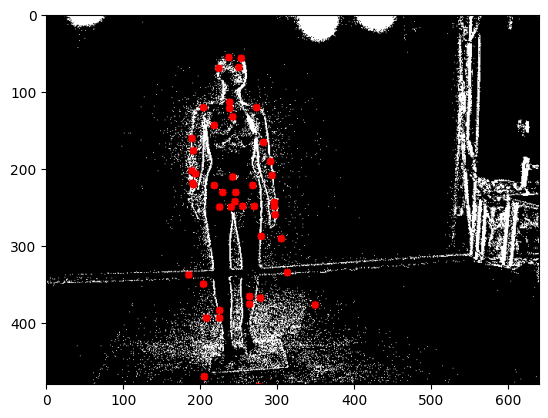

In [23]:
for i, p in enumerate(transformed_points):
    # print(p)
    x = int(p[0] / p[-1])
    y = int(p[1] / p[-1])
    # print(f"{x}, {y}")
    cv2.circle(dvs_frame, (x, y), 5, (255, 0, 0), -1)

plt.imshow(dvs_frame)

In [24]:
for i, p in enumerate(image_points[:]):
    ip = image_points[i]
    x = int(ip[0])
    y = int(ip[1])
    cv2.circle(dvs_frame, (x, y), 5, (255, 0, 0), -1)
    tp = reconstructed_points[i]
    # tx = int(tp[0] / tp[-1])
    # ty = int(tp[1] / tp[-1])
    tx = int(tp[0])
    ty = int(tp[1])
    cv2.circle(dvs_frame, (tx, ty), 5, (0, 0, 255), -1)

    cv2.line(dvs_frame, (x, y), (tx, ty), (0, 255, 0), 2)

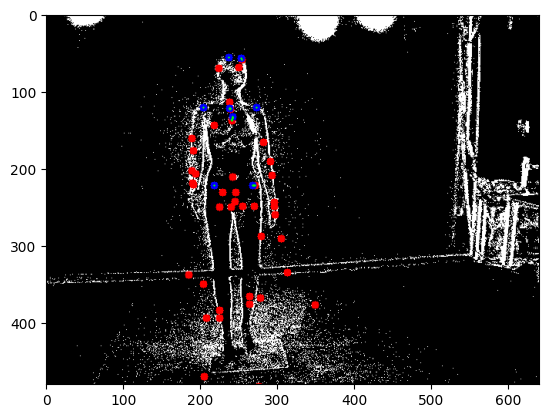

In [25]:
plt.imshow(dvs_frame)

In [26]:
R = P[:, :3]
t = P[:, -1]

In [27]:
R

array([[-0.00166368, -0.00016043,  0.00015172],
       [ 0.000254  , -0.00080852,  0.00219272],
       [-0.00073006,  0.00108377, -0.00093114]])

In [28]:
t

array([ 3.19536296, -0.82509644, -4.63567807])

In [29]:
w_to_cam = np.zeros((4, 4))
w_to_cam[:3, :] = P
w_to_cam[-1, -1] = 1.0
print(w_to_cam)

[[-1.66367994e-03 -1.60425577e-04  1.51721462e-04  3.19536296e+00]
 [ 2.54002366e-04 -8.08519420e-04  2.19271975e-03 -8.25096439e-01]
 [-7.30061288e-04  1.08376721e-03 -9.31137649e-04 -4.63567807e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [30]:
cam_to_w = np.linalg.inv(w_to_cam)
print(cam_to_w)

[[-5.65274107e+02  5.24082113e+00 -7.97653948e+01  1.44081344e+03]
 [-4.75012178e+02  5.77921786e+02  1.28353845e+03  7.94474857e+03]
 [-1.09670016e+02  6.68544078e+02  4.82517823e+02  3.13884613e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [31]:
cam_position = cam_to_w @ np.array([0.0, 0.0, 0.0, 1.0])
cam_position /= cam_position[-1]

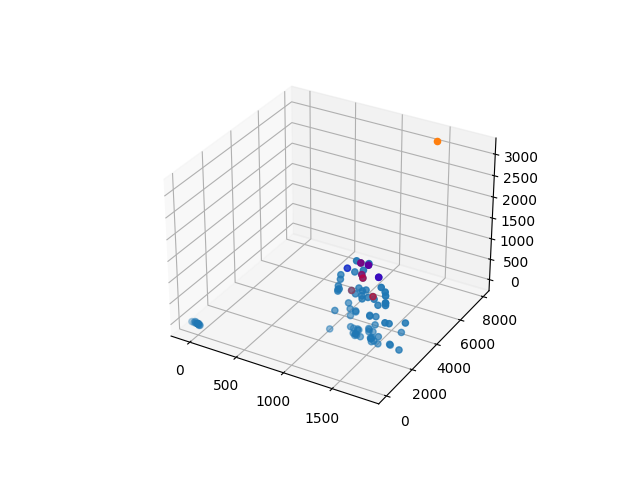

In [32]:
%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(points_all[:, 0], points_all[:, 1], points_all[:, 2])
skel = ax.scatter(vicon_points[:,0], vicon_points[:, 1], vicon_points[:, 2], c=points_colors)

ax.scatter(cam_position[0], cam_position[1], cam_position[2])

In [33]:
all_p = np.ones((points_all.shape[0], 4))
all_p[:, :3] = points_all[:, :3]
test_points = (w_to_cam @ all_p.transpose()).transpose()
for p in test_points:
    p /= p[-1]

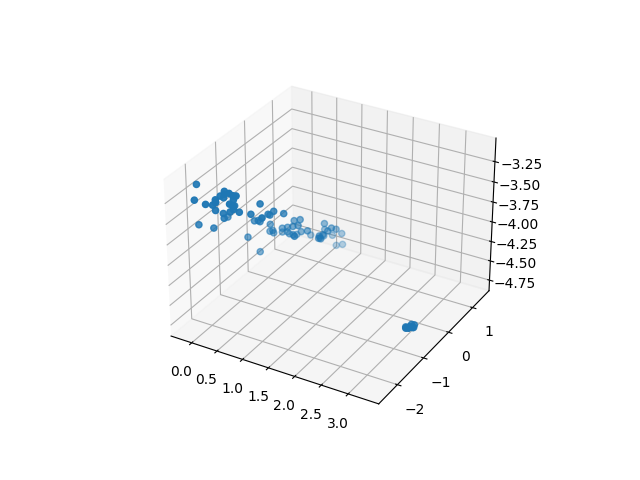

In [34]:
%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(test_points[:, 0], test_points[:, 1], test_points[:, 2])